# Definindo o lançamento com base nas datas do arquivo de compradores
Os códigos abaixo foram criados para identificar os lançamentos pela data da compra no relatório da hotmart. 
Para encapsular o código, é necessário editar a segunda parte para usar a parte do output da primeira que expressa com assertividade as divisões das campanhas de lançamento com base nas datas.

Listando arquivos no bucket new_times...
Encontrados 12 arquivos
Procurando arquivo de compradores...
Arquivos de compradores candidatos: ['raw_data/Pesquisa_L16.xlsx', 'raw_data/Pesquisa_L17.xlsx', 'raw_data/Pesquisa_L18.xlsx', 'raw_data/Pesquisa_L19.xlsx', 'raw_data/compradores_mario_L20.xls', 'raw_data/compradores_mario_L21.xls', 'raw_data/compradores_mario_l16_ate_l19.xlsx']
Arquivo de compradores encontrado: raw_data/compradores_mario_l16_ate_l19.xlsx
Baixando arquivo raw_data/compradores_mario_l16_ate_l19.xlsx do bucket new_times...
Arquivo baixado com sucesso. Tamanho: 669.70 KB
Arquivo carregado com sucesso. Total de registros: 2451

Informações do dataframe:
Colunas: ['Nome do Produto', 'Nome do Produtor', 'Documento do Produtor', 'Nome do Afiliado', 'Transação', 'Meio de Pagamento', 'Origem', 'Moeda', 'Preço do Produto', 'Moeda.1', 'Preço da Oferta', 'Taxa de Câmbio', 'Moeda.2', 'Preço Original', 'Número da Parcela', 'Recorrência', 'Data de Venda', 'Data de Confirmação', 'Sta

/var/tmp/ipykernel_7414/305354636.py:240: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df[date_column] = pd.to_datetime(df[date_column], errors='coerce')



Gráfico de distribuição temporal salvo como 'distribuicao_temporal.png'
Gráfico de períodos de lançamento salvo como 'periodos_lancamento.png'

=== RESUMO DOS PERÍODOS DE LANÇAMENTO ===
L16: de 2024-07-24 a 2024-08-09 (17 dias, 756 registros)
L17: de 2024-08-27 a 2024-09-22 (27 dias, 796 registros)
L18: de 2024-10-07 a 2024-10-28 (22 dias, 463 registros)
L19: de 2024-11-20 a 2024-11-30 (11 dias, 436 registros)


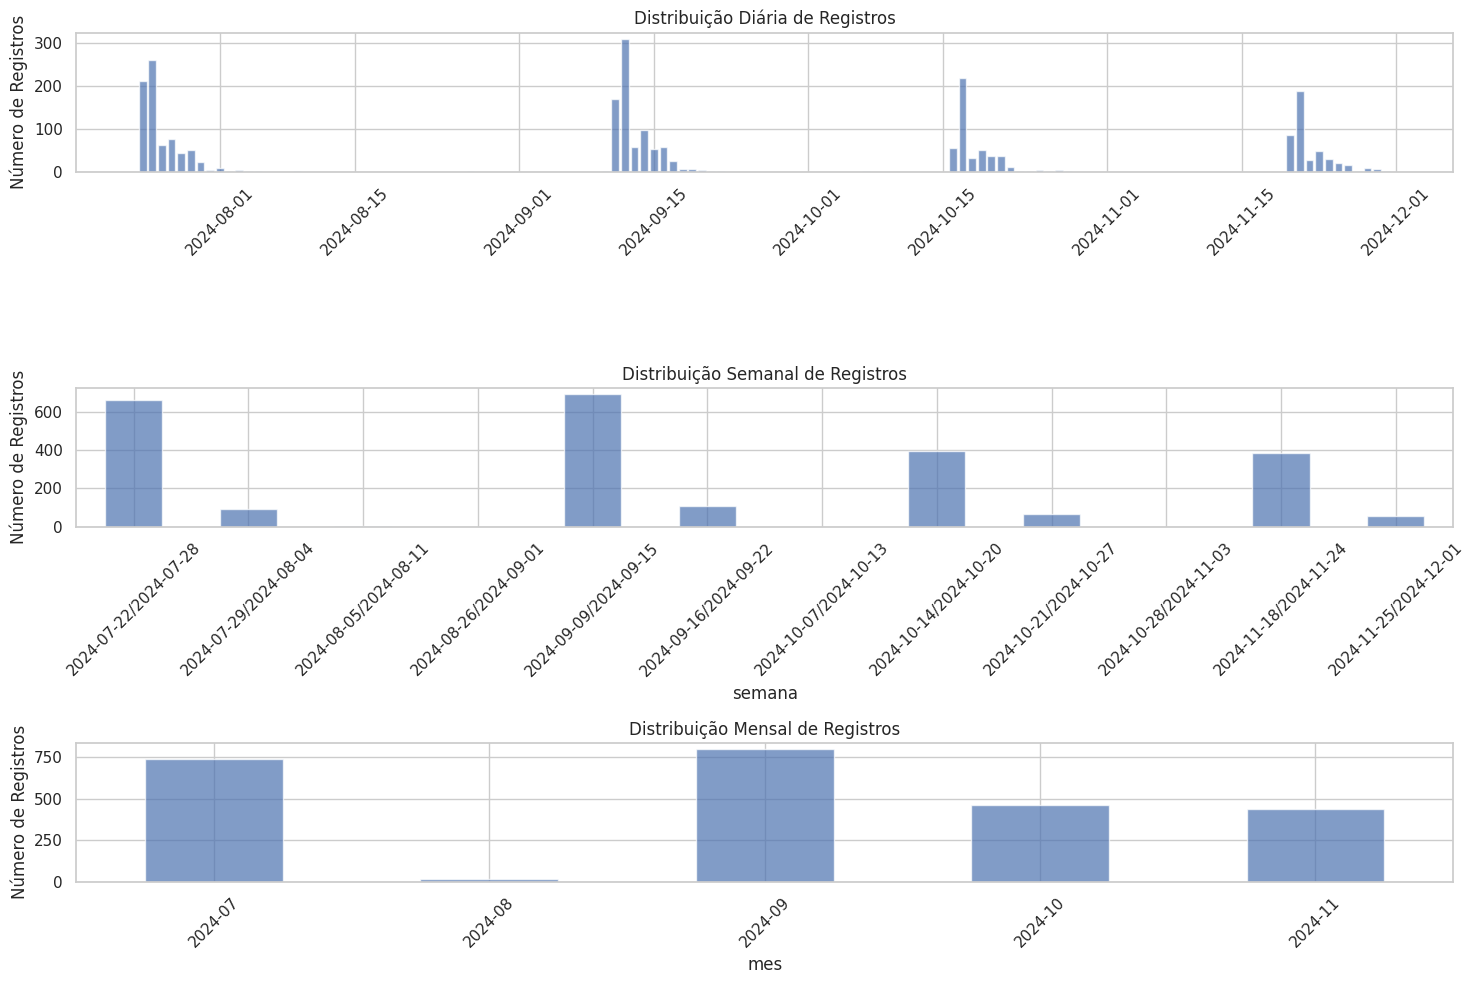

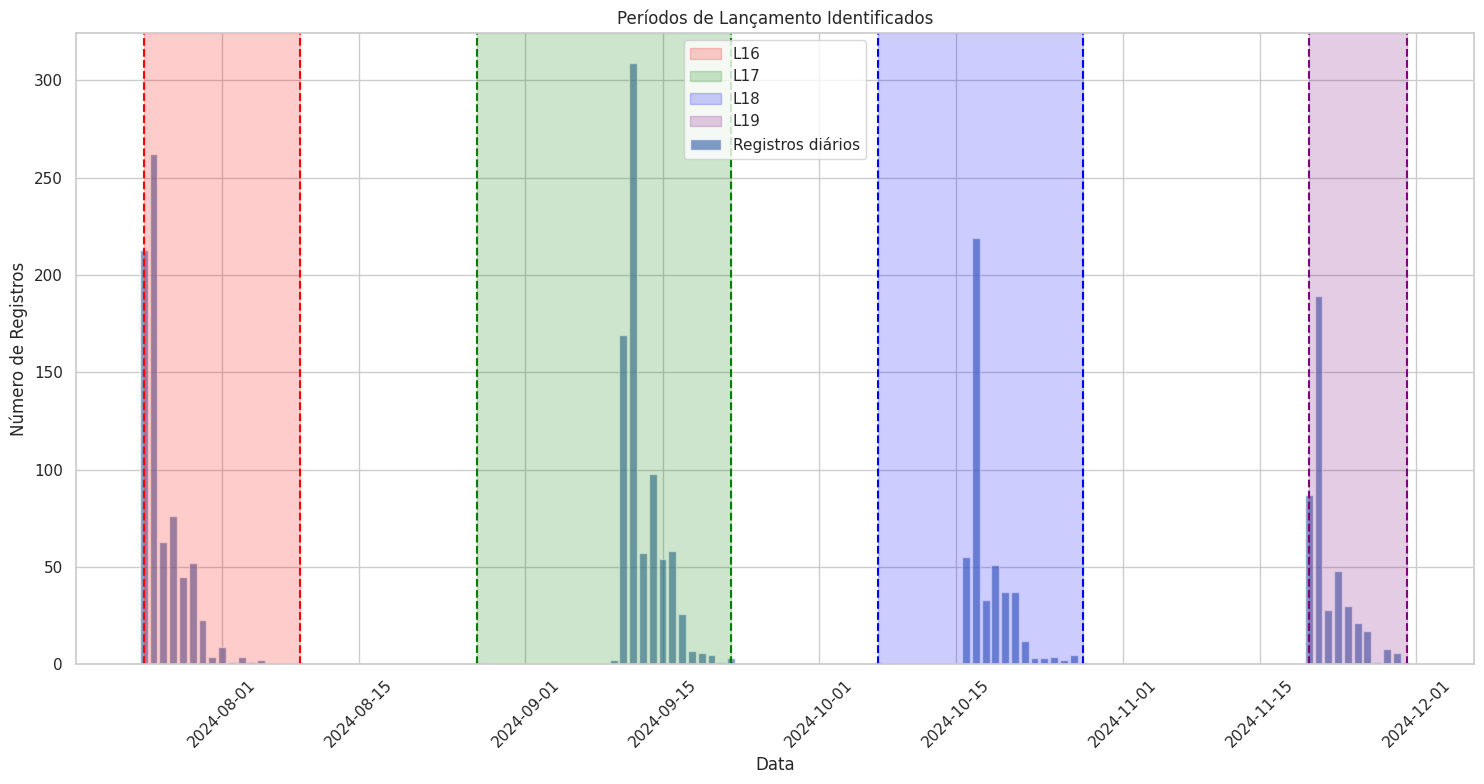

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from google.cloud import storage
import io
import os
from dateutil.parser import parse

# Configurações para visualização
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (14, 8)
sns.set(style="whitegrid")

def list_files_in_bucket(bucket_name, prefix=None):
    """Lista todos os arquivos em um bucket do GCS."""
    print(f"Listando arquivos no bucket {bucket_name}...")
    
    storage_client = storage.Client()
    bucket = storage_client.bucket(bucket_name)
    
    # Lista blobs com o prefixo especificado
    blobs = list(bucket.list_blobs(prefix=prefix))
    
    # Extrair nomes dos arquivos
    file_paths = [blob.name for blob in blobs]
    
    print(f"Encontrados {len(file_paths)} arquivos")
    return file_paths

def find_buyer_file(file_paths):
    """Encontra o arquivo de compradores na lista de arquivos."""
    print("Procurando arquivo de compradores...")
    
    # Critérios para identificar arquivos de compradores
    buyer_files = [f for f in file_paths if any(keyword in f.lower() for keyword in 
                                              ['comprador', 'mario', 'l16', 'l17', 'l18', 'l19'])]
    
    print(f"Arquivos de compradores candidatos: {buyer_files}")
    
    if buyer_files:
        # Preferir arquivo que menciona múltiplos lançamentos
        multi_launch_files = [f for f in buyer_files if any(keyword in f.lower() for keyword in 
                                                         ['l16_ate_l19', 'l16-l19', 'l16_l19'])]
        if multi_launch_files:
            return multi_launch_files[0]
        
        # Caso contrário, retornar o primeiro arquivo de compradores
        return buyer_files[0]
    
    return None

def download_from_gcs(bucket_name, source_blob_name):
    """Baixa um arquivo do Google Cloud Storage."""
    print(f"Baixando arquivo {source_blob_name} do bucket {bucket_name}...")
    
    storage_client = storage.Client()
    bucket = storage_client.bucket(bucket_name)
    blob = bucket.blob(source_blob_name)
    
    content = blob.download_as_bytes()
    print(f"Arquivo baixado com sucesso. Tamanho: {len(content)/1024:.2f} KB")
    
    return content

def parse_date_robust(date_str):
    """Faz a conversão de string para data de forma robusta."""
    if pd.isna(date_str) or not isinstance(date_str, str):
        return None
    
    date_str = date_str.strip()
    
    # Formatos esperados (do mais específico para o mais genérico)
    formats = [
        '%d/%m/%Y %H:%M:%S',  # 01/08/2024 00:00:40
        '%d/%m/%Y %H:%M',     # 01/08/2024 00:00
        '%d/%m/%Y',           # 01/08/2024
        '%Y-%m-%d %H:%M:%S',  # 2024-08-01 00:00:40
        '%Y-%m-%d',           # 2024-08-01
    ]
    
    for fmt in formats:
        try:
            return datetime.strptime(date_str, fmt)
        except ValueError:
            continue
    
    # Se nenhum dos formatos acima funcionar, usar o parser mais flexível
    try:
        return parse(date_str, dayfirst=True)  # Assumindo formato brasileiro (dia/mês)
    except:
        print(f"Não foi possível converter a data: {date_str}")
        return None

def detect_date_columns(df):
    """Identifica colunas que provavelmente contêm datas de venda."""
    potential_columns = []
    
    # Procurar por nomes de colunas comuns para datas de venda
    for col in df.columns:
        col_lower = col.lower()
        if ('data' in col_lower and ('venda' in col_lower or 'compra' in col_lower)) or \
           ('date' in col_lower and ('sale' in col_lower or 'purchase' in col_lower)) or \
           'data de venda' == col_lower:
            potential_columns.append(col)
    
    # Se não encontrou nada específico, procurar qualquer coluna com 'data' ou 'date'
    if not potential_columns:
        for col in df.columns:
            col_lower = col.lower()
            if 'data' in col_lower or 'date' in col_lower:
                potential_columns.append(col)
    
    return potential_columns

def detect_launches(df, date_column, gap_threshold=14, min_records=10):
    """
    Detecta períodos de lançamento com base em lacunas na distribuição temporal.
    
    Args:
        df: DataFrame com os dados
        date_column: Nome da coluna com as datas
        gap_threshold: Número de dias considerado como lacuna entre lançamentos
        min_records: Número mínimo de registros para considerar um período como lançamento
    
    Returns:
        DataFrame com os períodos de lançamento identificados
    """
    # Garantir que a coluna de data é datetime
    df = df.copy()
    
    # Criar coluna de data apenas (sem hora)
    df['data_apenas'] = df[date_column].dt.date
    
    # Contar registros por data
    daily_counts = df['data_apenas'].value_counts().sort_index()
    
    # Encontrar dias com atividade
    active_days = daily_counts.index.tolist()
    
    # Calcular a diferença em dias entre datas consecutivas
    date_diffs = []
    for i in range(1, len(active_days)):
        diff = (active_days[i] - active_days[i-1]).days
        date_diffs.append((active_days[i-1], active_days[i], diff))
    
    # Identificar lacunas significativas
    significant_gaps = [gap for gap in date_diffs if gap[2] > gap_threshold]
    
    # Usar lacunas para delimitar períodos de lançamento
    launch_periods = []
    
    if significant_gaps:
        # Primeiro período (do início até a primeira lacuna)
        start_date = active_days[0]
        end_date = significant_gaps[0][0]
        
        launch_periods.append((start_date, end_date))
        
        # Períodos intermediários
        for i in range(len(significant_gaps) - 1):
            start_date = significant_gaps[i][1]
            end_date = significant_gaps[i+1][0]
            launch_periods.append((start_date, end_date))
        
        # Último período (da última lacuna até o fim)
        start_date = significant_gaps[-1][1]
        end_date = active_days[-1]
        
        launch_periods.append((start_date, end_date))
    else:
        # Se não houver lacunas significativas, considerar todo o período como um único lançamento
        launch_periods.append((active_days[0], active_days[-1]))
    
    # Filtrar períodos com poucos registros
    filtered_periods = []
    for i, (start, end) in enumerate(launch_periods):
        # Converter para datetime para filtragem
        start_dt = datetime.combine(start, datetime.min.time())
        end_dt = datetime.combine(end, datetime.max.time())
        
        # Contar registros no período
        period_records = df[(df[date_column] >= start_dt) & (df[date_column] <= end_dt)].shape[0]
        
        if period_records >= min_records:
            filtered_periods.append({
                'lançamento': f'L{16+i}',  # Assumindo que começamos do L16
                'início': start,
                'fim': end,
                'duração_dias': (end - start).days + 1,
                'registros': period_records
            })
    
    return pd.DataFrame(filtered_periods)

# Função principal de análise
def analyze_buyer_data(df, date_column=None):
    """Analisa os dados de compradores para identificar períodos de lançamento."""
    print("\n=== ANÁLISE DE DADOS DE COMPRADORES ===")
    
    # 1. Verificar e identificar a coluna de data se não for especificada
    if date_column is None:
        potential_date_columns = detect_date_columns(df)
        
        if potential_date_columns:
            print(f"Colunas potenciais de data identificadas: {potential_date_columns}")
            date_column = potential_date_columns[0]
            print(f"Usando coluna: {date_column}")
        else:
            print("Nenhuma coluna de data identificada. Verificando todas as colunas...")
            
            # Tentar identificar qualquer coluna com valores de data
            for col in df.columns:
                # Verificar se os primeiros valores parecem datas
                sample = df[col].head(5).astype(str)
                date_patterns = ['/20', '-20', '201', '202', '203']  # Padrões comuns em datas
                
                if any(pattern in ''.join(sample.dropna().tolist()) for pattern in date_patterns):
                    print(f"Coluna com possíveis valores de data encontrada: {col}")
                    date_column = col
                    break
    
    if date_column is None:
        print("Não foi possível identificar uma coluna de data. Abortando análise.")
        return None
    
    print(f"\nProcessando coluna de data: {date_column}")
    
    # 2. Converter para datetime com tratamento robusto
    if df[date_column].dtype != 'datetime64[ns]':
        print("Convertendo para datetime...")
        
        # Verificar o tipo e exemplos de valores
        print(f"Tipo atual: {df[date_column].dtype}")
        print(f"Exemplo de valores: {df[date_column].head(3).tolist()}")
        
        # Tentar converter diretamente
        try:
            df[date_column] = pd.to_datetime(df[date_column], errors='coerce')
            print("Conversão direta bem-sucedida.")
        except Exception as e:
            print(f"Erro na conversão direta: {e}")
            print("Tentando conversão robusta...")
            
            # Se falhar, usar método robusto
            df[date_column] = df[date_column].apply(parse_date_robust)
    
    # 3. Verificar se a conversão foi bem-sucedida
    valid_dates = df[date_column].notna().sum()
    print(f"Datas válidas após conversão: {valid_dates} de {len(df)} ({valid_dates/len(df)*100:.2f}%)")
    
    if valid_dates == 0:
        print("Nenhuma data válida. Abortando análise.")
        return None
    
    # 4. Mostrar estatísticas básicas da coluna de data
    min_date = df[date_column].min()
    max_date = df[date_column].max()
    total_days = (max_date - min_date).days
    
    print(f"\nData mais antiga: {min_date}")
    print(f"Data mais recente: {max_date}")
    print(f"Intervalo total: {total_days} dias ({total_days/30.44:.1f} meses)")
    
    # 5. Distribuição temporal dos dados
    df['data_dia'] = df[date_column].dt.date
    daily_counts = df['data_dia'].value_counts().sort_index()
    
    print(f"\nDias com atividade: {len(daily_counts)}")
    print(f"Média de registros por dia ativo: {daily_counts.mean():.1f}")
    print(f"Máximo de registros em um dia: {daily_counts.max()} (em {daily_counts.idxmax()})")
    
    # 6. Agrupar por semana e mês para melhor visualização
    df['semana'] = df[date_column].dt.to_period('W')
    df['mes'] = df[date_column].dt.to_period('M')
    
    weekly_counts = df['semana'].value_counts().sort_index()
    monthly_counts = df['mes'].value_counts().sort_index()
    
    print("\nDistribuição por mês:")
    for period, count in monthly_counts.items():
        print(f"{period}: {count} registros")
    
    # 7. Detectar períodos de lançamento
    print("\nDetectando períodos de lançamento...")
    launch_periods = detect_launches(df, date_column)
    
    print("\nPeríodos de lançamento identificados:")
    print(launch_periods.to_string(index=False))
    
    # 8. Visualizações
    plt.figure(figsize=(15, 10))
    
    # 8.1. Distribuição diária
    plt.subplot(3, 1, 1)
    plt.bar(daily_counts.index, daily_counts.values, alpha=0.7)
    plt.title('Distribuição Diária de Registros')
    plt.ylabel('Número de Registros')
    plt.xticks(rotation=45)
    
    # 8.2. Distribuição semanal
    plt.subplot(3, 1, 2)
    weekly_counts.plot(kind='bar', alpha=0.7)
    plt.title('Distribuição Semanal de Registros')
    plt.ylabel('Número de Registros')
    plt.xticks(rotation=45)
    
    # 8.3. Distribuição mensal
    plt.subplot(3, 1, 3)
    monthly_counts.plot(kind='bar', alpha=0.7)
    plt.title('Distribuição Mensal de Registros')
    plt.ylabel('Número de Registros')
    plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.savefig('distribuicao_temporal.png')
    print("\nGráfico de distribuição temporal salvo como 'distribuicao_temporal.png'")
    
    # 9. Visualizar os períodos de lançamento identificados
    plt.figure(figsize=(15, 8))
    plt.bar(daily_counts.index, daily_counts.values, alpha=0.7, label='Registros diários')
    
    # Adicionar linhas verticais para os períodos de lançamento
    colors = ['red', 'green', 'blue', 'purple']
    for i, row in launch_periods.iterrows():
        color = colors[i % len(colors)]
        plt.axvspan(row['início'], row['fim'], alpha=0.2, color=color, label=row['lançamento'])
        plt.axvline(row['início'], linestyle='--', color=color)
        plt.axvline(row['fim'], linestyle='--', color=color)
    
    plt.title('Períodos de Lançamento Identificados')
    plt.ylabel('Número de Registros')
    plt.xlabel('Data')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig('periodos_lancamento.png')
    print("Gráfico de períodos de lançamento salvo como 'periodos_lancamento.png'")
    
    return launch_periods

# Script principal
try:
    # 1. Listar arquivos no bucket
    bucket_name = "new_times"
    all_files = list_files_in_bucket(bucket_name, prefix="raw_data/")
    
    # 2. Encontrar o arquivo de compradores
    buyer_file = find_buyer_file(all_files)
    
    if buyer_file:
        print(f"Arquivo de compradores encontrado: {buyer_file}")
        
        # 3. Baixar o arquivo
        content = download_from_gcs(bucket_name, buyer_file)
        
        # 4. Carregar para um DataFrame
        if buyer_file.endswith('.csv'):
            df = pd.read_csv(io.BytesIO(content))
        else:  # Excel
            df = pd.read_excel(io.BytesIO(content), engine='openpyxl')
        
        print(f"Arquivo carregado com sucesso. Total de registros: {len(df)}")
        
        # 5. Exibir informações básicas
        print("\nInformações do dataframe:")
        print(f"Colunas: {df.columns.tolist()}")
        print(f"Tipos de dados: {df.dtypes.value_counts().to_dict()}")
        
        # 6. Procurar pela coluna "Data de Venda"
        date_column = "Data de Venda" if "Data de Venda" in df.columns else None
        
        # 7. Analisar os dados
        launch_periods = analyze_buyer_data(df, date_column)
        
        # 8. Mostrar resumo final
        if launch_periods is not None:
            print("\n=== RESUMO DOS PERÍODOS DE LANÇAMENTO ===")
            for i, row in launch_periods.iterrows():
                print(f"{row['lançamento']}: de {row['início']} a {row['fim']} ({row['duração_dias']} dias, {row['registros']} registros)")
    else:
        print("Nenhum arquivo de compradores encontrado no bucket.")
        
except Exception as e:
    print(f"Erro durante a análise: {e}")
    import traceback
    traceback.print_exc()

Usando arquivo de compradores: raw_data/compradores_mario_l16_ate_l19.xlsx
Arquivo carregado com sucesso. Total de registros: 2451
Usando coluna de data: Data de Venda
Datas válidas: 2451 de 2451 (100.00%)

Períodos de lançamento definidos:
lançamento     início        fim
       L16 2024-07-24 2024-08-09
       L17 2024-08-27 2024-09-22
       L18 2024-10-07 2024-10-28
       L19 2024-11-20 2024-11-30
Lançamento L16: 756 registros (de 2024-07-24 a 2024-08-09)
Lançamento L17: 796 registros (de 2024-08-27 a 2024-09-22)
Lançamento L18: 463 registros (de 2024-10-07 a 2024-10-28)
Lançamento L19: 436 registros (de 2024-11-20 a 2024-11-30)

=== ANÁLISE DE DADOS POR LANÇAMENTO ===

Lançamento L16:
  Período: 2024-07-24 a 2024-08-09 (17 dias)
  Total de registros: 756
  Dias com registros: 14
  Média de registros por dia: 54.00
  Dia com mais registros: 2024-07-25 (262 registros)

Lançamento L17:
  Período: 2024-08-27 a 2024-09-22 (27 dias)
  Total de registros: 796
  Dias com registros: 14
  

/var/tmp/ipykernel_7414/32014474.py:72: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df[date_column] = pd.to_datetime(df[date_column], errors='coerce')



Gráfico comparativo salvo como 'comparativo_lancamentos.png'

=== EXPORTANDO DATAFRAMES POR LANÇAMENTO ===
Lançamento L16: 756 registros exportados para launch_data/L16_data.csv
Lançamento L17: 796 registros exportados para launch_data/L17_data.csv
Lançamento L18: 463 registros exportados para launch_data/L18_data.csv
Lançamento L19: 436 registros exportados para launch_data/L19_data.csv

Processamento concluído com sucesso!
Foram gerados 4 arquivos de dados por lançamento.


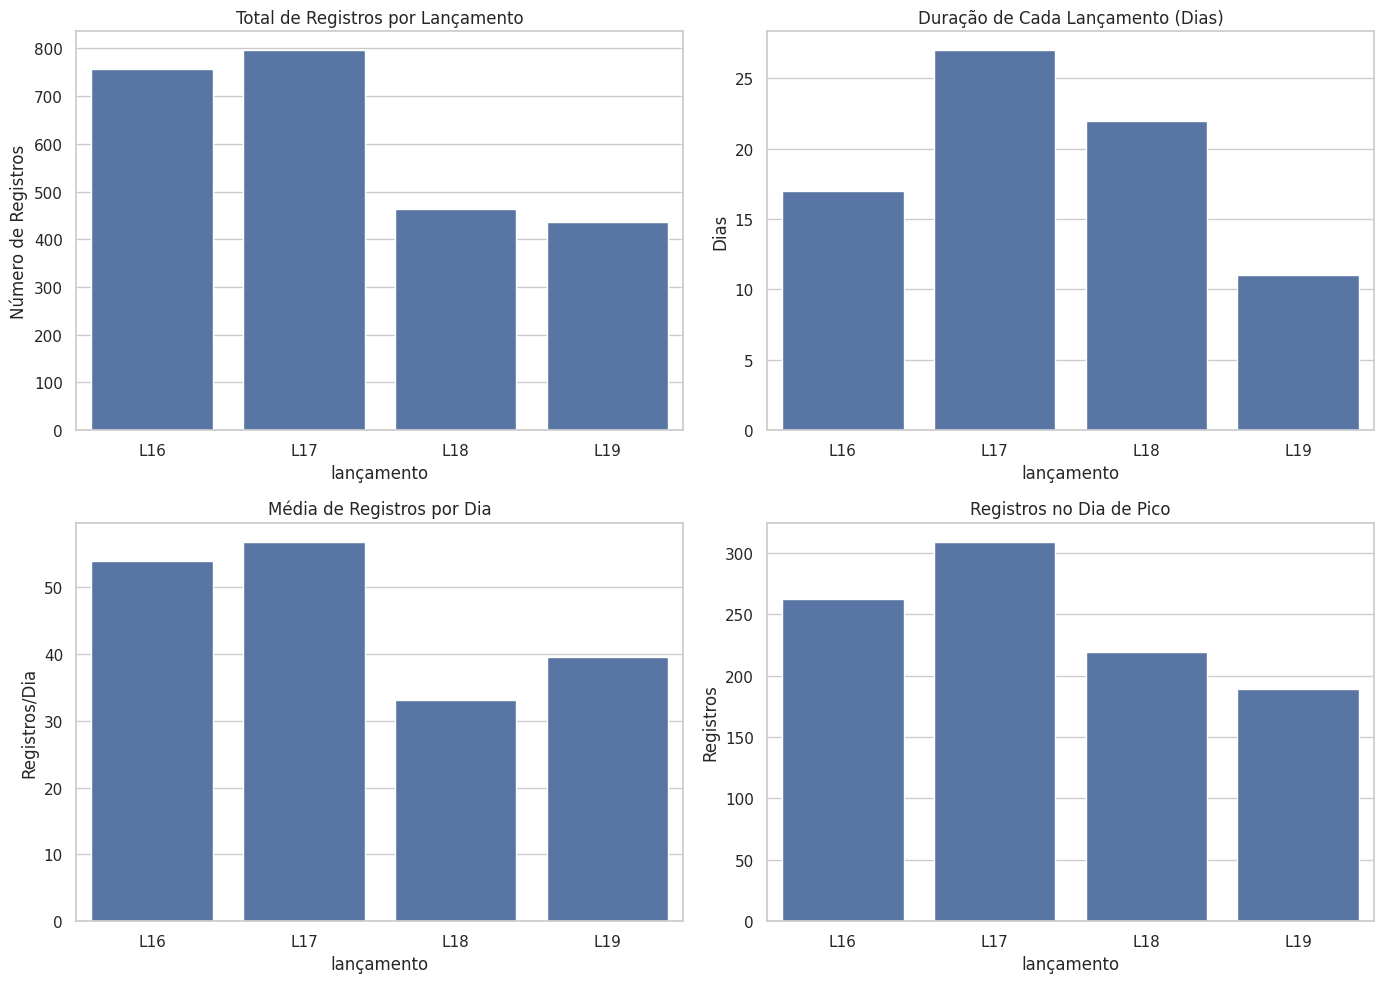

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from google.cloud import storage
import io
import os
from dateutil.parser import parse

# Função para baixar e carregar o arquivo de compradores
def load_buyers_data(bucket_name, all_files=None):
    """Baixa e carrega o arquivo de compradores do bucket."""
    if all_files is None:
        # Listar arquivos no bucket
        storage_client = storage.Client()
        bucket = storage_client.bucket(bucket_name)
        blobs = list(bucket.list_blobs(prefix="raw_data/"))
        all_files = [blob.name for blob in blobs]
    
    # Encontrar arquivo de compradores
    buyer_files = [f for f in all_files if any(keyword in f.lower() for keyword in 
                                             ['comprador', 'mario', 'l16', 'l17', 'l18', 'l19'])]
    
    if not buyer_files:
        raise ValueError("Nenhum arquivo de compradores encontrado no bucket.")
    
    # Preferir arquivo que menciona múltiplos lançamentos
    multi_launch_files = [f for f in buyer_files if any(keyword in f.lower() for keyword in 
                                                     ['l16_ate_l19', 'l16-l19', 'l16_l19'])]
    buyer_file = multi_launch_files[0] if multi_launch_files else buyer_files[0]
    
    print(f"Usando arquivo de compradores: {buyer_file}")
    
    # Baixar arquivo
    storage_client = storage.Client()
    bucket = storage_client.bucket(bucket_name)
    blob = bucket.blob(buyer_file)
    content = blob.download_as_bytes()
    
    # Carregar para DataFrame
    if buyer_file.endswith('.csv'):
        df = pd.read_csv(io.BytesIO(content))
    else:  # Excel
        df = pd.read_excel(io.BytesIO(content), engine='openpyxl')
    
    print(f"Arquivo carregado com sucesso. Total de registros: {len(df)}")
    return df

# Função para identificar e processar a coluna de data
def process_date_column(df, date_column=None):
    """Identifica e processa a coluna de data no DataFrame."""
    # Identificar coluna de data se não for especificada
    if date_column is None:
        potential_date_columns = [col for col in df.columns if 'data' in col.lower() and ('venda' in col.lower() or 'compra' in col.lower())]
        
        if potential_date_columns:
            date_column = potential_date_columns[0]
        else:
            # Procurar qualquer coluna com 'data' ou 'date'
            potential_date_columns = [col for col in df.columns if 'data' in col.lower() or 'date' in col.lower()]
            date_column = potential_date_columns[0] if potential_date_columns else None
    
    if date_column is None:
        raise ValueError("Não foi possível identificar uma coluna de data no DataFrame.")
    
    print(f"Usando coluna de data: {date_column}")
    
    # Converter para datetime
    if df[date_column].dtype != 'datetime64[ns]':
        try:
            df[date_column] = pd.to_datetime(df[date_column], errors='coerce')
        except:
            # Converter manualmente com tratamento robusto
            df[date_column] = df[date_column].apply(lambda x: parse(str(x), dayfirst=True) if pd.notna(x) else None)
    
    # Verificar conversão
    valid_dates = df[date_column].notna().sum()
    print(f"Datas válidas: {valid_dates} de {len(df)} ({valid_dates/len(df)*100:.2f}%)")
    
    return df, date_column

# Função para definir manualmente os períodos de lançamento
def define_launch_periods():
    """Define manualmente os períodos de lançamento com base na análise prévia."""
    # Nota: Substitua estas datas pelos resultados da sua análise anterior
    launch_periods = [
        {"lançamento": "L16", "início": "2024-07-24", "fim": "2024-08-09"},
        {"lançamento": "L17", "início": "2024-08-27", "fim": "2024-09-22"},
        {"lançamento": "L18", "início": "2024-10-07", "fim": "2024-10-28"},
        {"lançamento": "L19", "início": "2024-11-20", "fim": "2024-11-30"}        
    ]
    
    # Converter strings para datetime
    for period in launch_periods:
        period["início"] = pd.to_datetime(period["início"]).date()
        period["fim"] = pd.to_datetime(period["fim"]).date()
    
    return pd.DataFrame(launch_periods)

# Função para segmentar o DataFrame por lançamentos
def split_by_launches(df, date_column, launch_periods):
    """Divide o DataFrame em múltiplos DataFrames, um para cada lançamento."""
    launch_dfs = {}
    
    for _, row in launch_periods.iterrows():
        launch_id = row["lançamento"]
        start_date = row["início"]
        end_date = row["fim"]
        
        # Converter datas para datetime para comparação correta
        start_datetime = pd.Timestamp(start_date)
        end_datetime = pd.Timestamp(end_date).replace(hour=23, minute=59, second=59)
        
        # Filtrar registros para este lançamento
        launch_df = df[(df[date_column] >= start_datetime) & (df[date_column] <= end_datetime)].copy()
        
        # Adicionar coluna identificando o lançamento
        launch_df["lançamento"] = launch_id
        
        # Armazenar no dicionário
        launch_dfs[launch_id] = launch_df
        
        print(f"Lançamento {launch_id}: {len(launch_df)} registros (de {start_date} a {end_date})")
    
    return launch_dfs

# Função para analisar dados de cada lançamento
def analyze_launch_data(launch_dfs, date_column):
    """Realiza análise básica dos dados de cada lançamento."""
    print("\n=== ANÁLISE DE DADOS POR LANÇAMENTO ===")
    
    # Análise comparativa
    summary = []
    
    for launch_id, df in launch_dfs.items():
        if len(df) == 0:
            print(f"Lançamento {launch_id}: Nenhum registro encontrado")
            continue
        
        # Estatísticas básicas
        start_date = df[date_column].min().date()
        end_date = df[date_column].max().date()
        duration = (end_date - start_date).days + 1
        
        # Contagem por dia
        df['data_dia'] = df[date_column].dt.date
        days_with_records = df['data_dia'].nunique()
        records_per_day = len(df) / days_with_records if days_with_records > 0 else 0
        
        # Pico de registros em um dia
        daily_counts = df['data_dia'].value_counts()
        peak_day = daily_counts.idxmax() if not daily_counts.empty else None
        peak_count = daily_counts.max() if not daily_counts.empty else 0
        
        # Adicionar ao resumo
        summary.append({
            "lançamento": launch_id,
            "total_registros": len(df),
            "início": start_date,
            "fim": end_date,
            "duração_dias": duration,
            "dias_com_registros": days_with_records,
            "média_registros_por_dia": records_per_day,
            "dia_pico": peak_day,
            "registros_no_pico": peak_count
        })
        
        print(f"\nLançamento {launch_id}:")
        print(f"  Período: {start_date} a {end_date} ({duration} dias)")
        print(f"  Total de registros: {len(df)}")
        print(f"  Dias com registros: {days_with_records}")
        print(f"  Média de registros por dia: {records_per_day:.2f}")
        print(f"  Dia com mais registros: {peak_day} ({peak_count} registros)")
    
    # Criar DataFrame de resumo
    summary_df = pd.DataFrame(summary)
    
    # Visualização comparativa
    if len(summary_df) > 0:
        plt.figure(figsize=(14, 10))
        
        # Registros por lançamento
        plt.subplot(2, 2, 1)
        sns.barplot(x='lançamento', y='total_registros', data=summary_df)
        plt.title('Total de Registros por Lançamento')
        plt.ylabel('Número de Registros')
        
        # Duração por lançamento
        plt.subplot(2, 2, 2)
        sns.barplot(x='lançamento', y='duração_dias', data=summary_df)
        plt.title('Duração de Cada Lançamento (Dias)')
        plt.ylabel('Dias')
        
        # Média de registros por dia
        plt.subplot(2, 2, 3)
        sns.barplot(x='lançamento', y='média_registros_por_dia', data=summary_df)
        plt.title('Média de Registros por Dia')
        plt.ylabel('Registros/Dia')
        
        # Registros no pico
        plt.subplot(2, 2, 4)
        sns.barplot(x='lançamento', y='registros_no_pico', data=summary_df)
        plt.title('Registros no Dia de Pico')
        plt.ylabel('Registros')
        
        plt.tight_layout()
        plt.savefig('comparativo_lancamentos.png')
        print("\nGráfico comparativo salvo como 'comparativo_lancamentos.png'")
    
    return summary_df

# Função para exportar os DataFrames de lançamentos
def export_launch_dataframes(launch_dfs, export_format='csv'):
    """Exporta os DataFrames de cada lançamento para arquivos separados."""
    print("\n=== EXPORTANDO DATAFRAMES POR LANÇAMENTO ===")
    
    # Criar diretório para exportação
    export_dir = 'launch_data'
    os.makedirs(export_dir, exist_ok=True)
    
    exported_files = []
    
    for launch_id, df in launch_dfs.items():
        if len(df) == 0:
            print(f"Lançamento {launch_id}: Nenhum registro para exportar")
            continue
        
        # Nome do arquivo
        filename = f"{export_dir}/{launch_id}_data.{export_format}"
        
        # Exportar conforme o formato
        if export_format.lower() == 'csv':
            df.to_csv(filename, index=False)
        elif export_format.lower() == 'excel' or export_format.lower() == 'xlsx':
            df.to_excel(filename, index=False)
        elif export_format.lower() == 'parquet':
            df.to_parquet(filename, index=False)
        
        print(f"Lançamento {launch_id}: {len(df)} registros exportados para {filename}")
        exported_files.append(filename)
    
    return exported_files

# Função principal
def main():
    """Função principal para executar todo o processo."""
    try:
        # 1. Carregar dados
        bucket_name = "new_times"
        df = load_buyers_data(bucket_name)
        
        # 2. Processar coluna de data
        df, date_column = process_date_column(df, date_column="Data de Venda")
        
        # 3. Definir períodos de lançamento
        # Opção 1: Usar períodos definidos manualmente
        launch_periods = define_launch_periods()
        
        # Opção 2: Alternativamente, você pode usar os períodos detectados automaticamente
        # da análise anterior (não implementado aqui)
        
        print("\nPeríodos de lançamento definidos:")
        print(launch_periods.to_string(index=False))
        
        # 4. Dividir o DataFrame por lançamentos
        launch_dfs = split_by_launches(df, date_column, launch_periods)
        
        # 5. Analisar dados de cada lançamento
        summary_df = analyze_launch_data(launch_dfs, date_column)
        
        # 6. Exportar DataFrames por lançamento
        exported_files = export_launch_dataframes(launch_dfs, export_format='csv')
        
        print("\nProcessamento concluído com sucesso!")
        print(f"Foram gerados {len(exported_files)} arquivos de dados por lançamento.")
        
        return launch_dfs, summary_df
        
    except Exception as e:
        print(f"Erro durante o processamento: {e}")
        import traceback
        traceback.print_exc()
        return None, None

# Executar o script
if __name__ == "__main__":
    launch_dfs, summary_df = main()